In [16]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

ModuleNotFoundError: No module named 'tensorflow'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# change here to your dataset path

# PATH = 'IMDB Dataset.csv'
PATH = '/content/drive/MyDrive/imdb/IMDB Dataset.csv'

## **1. Background**

![Natural language processing](https://landbot.io/wp-content/uploads/2019/11/natural-language-processing-chatbot.jpg)

**What is Natural Language Processing?**

From wikipedia, Natural language processing (NLP) is a subfield of linguistics, computer science, information engineering, and artificial intelligence concerned with the interactions between computers and human (natural) languages, in particular how to program computers to process and analyze large amounts of natural language data.

**What is Sentiment Classification?**

Sentiment analysis (also known as opinion mining or emotion AI) refers to the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. Sentiment analysis is widely applied to voice of the customer materials such as reviews and survey responses, online and social media, and healthcare materials for applications that range from marketing to customer service to clinical medicine.

**What is Tokenizer?**

Tokenization is a necessary first step in many natural language processing tasks, such as word counting, parsing, spell checking, corpus generation, and statistical analysis of text.

Tokenizer is a compact pure-Python (2 and 3) executable program and module for tokenizing Icelandic text. It converts input text to streams of tokens, where each token is a separate word, punctuation sign, number/amount, date, e-mail, URL/URI, etc. It also segments the token stream into sentences, considering corner cases such as abbreviations and dates in the middle of sentences.[Tokenizer](https://pypi.org/project/tokenizer/)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Serfati/imdb_sentiment_analysis)

In [3]:
# !pip install -r requirements.txt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter

In [5]:
import re
import os
import pandas as pd
import numpy as np

In [6]:
# visualization
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [7]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

## **2. Data exploratory analysis**


### **2.1 Data overview**

![IMDB 50 review datasets](https://o.aolcdn.com/images/dims?quality=85&image_uri=https%3A%2F%2Fo.aolcdn.com%2Fimages%2Fdims%3Fcrop%3D908%252C537%252C0%252C0%26quality%3D85%26format%3Djpg%26resize%3D1600%252C947%26image_uri%3Dhttps%253A%252F%252Fs.yimg.com%252Fos%252Fcreatr-uploaded-images%252F2019-08%252F560e5d20-c833-11e9-bf26-36635805fe83%26client%3Da1acac3e1b3290917d92%26signature%3D639a4965c41ca6cec13652498f65cfc97170ea5d&client=amp-blogside-v2&signature=765e155477177a69b93eac5611145d4241be6071)

This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided.

**Dataset**

The core dataset contains 50,000 reviews. The overall distribution of labels is balanced (25k pos and 25k neg). We also include an additional 50,000 unlabeled documents for unsupervised learning.

### **2.2 Data Exploration**

The first step is to load the data to global environment.

In [9]:
df = pd.read_csv(PATH)

We could see some abnormal words such as <br /><br />, then we should replace them by a null or space value.

Text(0.5, 1.0, 'Words occurrence frequency')

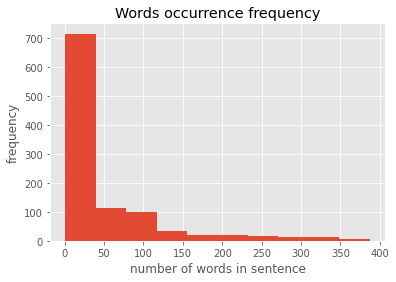

In [10]:
plt.figure()
plt.hist(df['review'].str.split().apply(len).value_counts())
plt.xlabel('number of words in sentence')
plt.ylabel('frequency')
plt.title('Words occurrence frequency')

In [11]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [13]:
df["review"][0][:250]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of "

In [14]:
df["sentiment"][0]

'positive'

In [15]:
df["review"].groupby(df["sentiment"]).count()

sentiment
negative    25000
positive    25000
Name: review, dtype: int64

Text(0.5, 1.0, 'Reviews polarity')

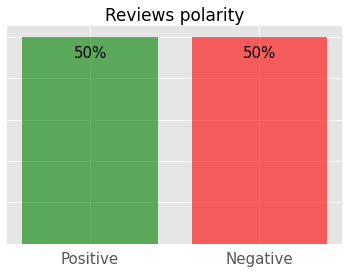

In [16]:
s = df['sentiment'].value_counts()
s = (s/s.sum())*100

plt.figure()
bars = plt.bar(s.index, s.values, color = ['green', 'red'], alpha = .6)
plt.xticks(s.index, ['Positive', 'Negative'], fontsize = 15)
plt.tick_params(bottom = False, top = False, left = False, right = False, labelleft = False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 5, s = str(bar.get_height())[:2] + '%', ha = 'center', fontsize = 15)
plt.title('Reviews polarity', fontsize = 17)

### **2.3 Data pre-processing**

**Text Cleaning**

0.Label Encoder

1.Remove html tags

2.Remove special characters

3.Converting every thing to lower case

4.Removing Stop words

5.Stemming

6.Remove extra spaces

7.Lemmatization

In [17]:
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [18]:
df['review'] = df['review'].str.replace('<br />','')

In [19]:
# function to remove special characters
df["review"] = df["review"].apply(lambda x: re.sub("[^0-9a-zA-Z]",' ', x))

In [20]:
df['review'] = df['review'].str.lower()

In [21]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Stop Words Removal**

We'll remove the stop words for better prediction.

In [22]:
from tqdm import tqdm
nltk.download('punkt')
pbar = tqdm(total=df.shape[0], leave=True, position=0)

def remove_sw(review):
    tokens = word_tokenize(review)
    tokens = [w for w in tokens if not w in stop_words]
    pbar.update(1)
    return " ".join(tokens)

df["review"] = df["review"].apply(remove_sw)
pbar.close()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


100%|██████████| 50000/50000 [00:50<00:00, 988.03it/s]


**Porter Stemmer**

For this particular dataset the PorterStemmer does not bring better performance, so it is better to skip this step.

In [23]:
pbar = tqdm(total=df.shape[0], leave=True, position=0)
ps = PorterStemmer()

def stem(text):
    pbar.update(1)
    return ' '.join([ps.stem(word) for word in text.split()])

df["review"] = df["review"].apply(stem)
pbar.close()

100%|██████████| 50000/50000 [01:56<00:00, 430.04it/s]


In [24]:
nltk.download('punkt')
#Creating a Lemmatizer for preprocessing
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
df["review"] = df["review"].apply(lambda x: re.sub(" +"," ", x))

In [26]:
# A cleaned review after pre proccessing
df['review'][0]

'one review mention watch 1 oz episod hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement never far away would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanc oz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort view that get touch darker side'

In [27]:
neg = df[df['sentiment'] == 0]
pos = df[df['sentiment'] == 1]

In [28]:
import plotly.express as px
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [29]:
most_common_uni = get_top_text_ngrams(neg.review,10,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Unigram - Commmon Words in Negative Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [30]:
most_common_uni = get_top_text_ngrams(pos.review,10,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Unigram - Commmon Words in Positive Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [31]:
most_common_uni = get_top_text_ngrams(pos.review,10,2)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Bigram - Commmon Words in Positive Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [32]:
most_common_uni = get_top_text_ngrams(pos.review,10,2)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Bigram - Commmon Words in Positive Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [33]:
X = df['review']
y = df['sentiment']

Split data to train and test for modeling and performance evaluation.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

print('Training dataset : {} reviews'.format(X_train.shape[0]))
print('Testing dataset : {} reviews'.format(X_test.shape[0]))

Training dataset : 25000 reviews
Testing dataset : 25000 reviews


In [35]:
y_test.value_counts()

1    12517
0    12483
Name: sentiment, dtype: int64

## **3. Modeling**

### 3.1 Feature Extraction using TF-IDF algorithm

![TFIDF](https://miro.medium.com/max/532/0*bHkPdhgfnyTs4un_)

In scikit-learn, the TF-IDF algorithm is implemented using **TfidfTransformer**. This transformer needs the count matrix which it will transform later. Hence, we use **CountVectorizer** first.
Alternatively, one can use **TfidfVectorizer**, which is the equivalent of CountVectorizer followed by TfidfTransformer

In [36]:
nltk.download('wordnet')
tfidfVect =    TfidfVectorizer( max_df = 0.5,
                                sublinear_tf=True,
                                lowercase = True, 
                                ngram_range = (1,2), 
                                tokenizer = LemmaTokenizer(),
                                stop_words = 'english',
                                min_df = 1,
                                use_idf = True,
                                # max_features = 1000,
                                strip_accents = 'ascii'
                                )

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [37]:
%time features = tfidfVect.fit_transform(X_train)
features.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.



CPU times: user 39.4 s, sys: 325 ms, total: 39.7 s
Wall time: 39.7 s


(25000, 1517681)

## Unsupervised Learning Approach

Now, all that’s left to do is use a machine learning algorithm. We can summarize all that we have done so far using a scikit-learn pipeline.

In [38]:
model = KMeans(n_clusters=2, random_state=42)

#fit the model with data (occurs in-place)
model.fit(features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [39]:
features_test = tfidfVect.transform(X_test)

We can find predictions using the predict() method.

In [ ]:
pred = model.predict(features_test)
pred = pd.DataFrame(pred)

To evaluate the predictions, we use different classification metrics.

In [41]:
print("test accuracy score: {0:.3f}%".format(accuracy_score(y_test, pred)*100))
#accuracy_score ==> 74.360%

test accuracy score: 74.360%


Text(0.5, 1.0, 'KMeans Confusion Matrix')

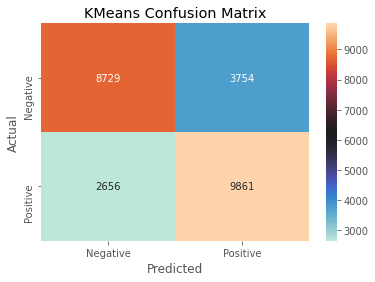

In [42]:
sn.heatmap(confusion_matrix(y_test, pred), annot=True, cmap="icefire",xticklabels=['Negative', 'Positive'],yticklabels=
['Negative', 'Positive'], fmt='g')

sn.color_palette("pastel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KMeans Confusion Matrix')

We have obtained than 74.4% accuracy in predicting whether the review message is positive or negative, and we have performed feature extraction from the raw text in the process.

In [43]:
# pca = PCA(n_components=2)
# reduced_features = pca.fit_transform(features.toarray()[:1000])
# reduced_cluster_centers = pca.transform(model.cluster_centers_)

# plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=model.predict(features), s=10)
# plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:, 1], marker='x', s=150, c='b')

## Supervised Learning Approach

## TfIdfVectorizer Feature Extraction 
**Naive Bayes Classifier for Multinomial**

In [44]:
#instantiate the model (with the default parameters)
mnb = MultinomialNB()

#fit the model with data (occurs in-place)
mnb.fit(features, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [45]:
print("Training accuracy of MultinomialNB using TfIdfVectorizer: {0:.3f}%".format(accuracy_score(y_train, mnb.predict(features))*100))
#Training accuracy of MultinomialNB using TfIdfVectorizer: 98.848%

Training accuracy of MultinomialNB using TfIdfVectorizer: 98.848%


**Stochastic Gradient Descent Classifier**

In [46]:
from sklearn.linear_model import SGDClassifier
#instantiate the model (with the default parameters)
sgd = SGDClassifier()

#fit the model with data (occurs in-place)
sgd.fit(features, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [48]:
print("Training accuracy of SGDClassifier using TfIdfVectorizer: {0:.3f}%".format(accuracy_score(y_train, sgd.predict(features))*100))

Training accuracy of SGDClassifier using TfIdfVectorizer: 96.800%


**Logistic Regression**

In [49]:
from sklearn.linear_model import LogisticRegression
#instantiate the model (with the default parameters)
lr = LogisticRegression()

#fit the model with data (occurs in-place)
lr.fit(features, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
print("Training accuracy of Logistic Regression using TfIdfVectorizer: {0:.3f}%".format(accuracy_score(y_train, lr.predict(features))*100))
#Training accuracy of Logistic Regression using TfIdfVectorizer: 96.088%

Training accuracy of Logistic Regression using TfIdfVectorizer: 96.088%


### 3.1 Feature Extraction using Count Vectorizer

In [51]:
cv=CountVectorizer( max_df = 0.5,
                    lowercase = True, 
                    ngram_range = (1,2), 
                    tokenizer = LemmaTokenizer(),
                    stop_words = 'english',
                    min_df = 1,
                    )

In [52]:
%time bow_features = cv.fit_transform(X_train)
bow_features.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.



CPU times: user 37.5 s, sys: 305 ms, total: 37.8 s
Wall time: 37.8 s


(25000, 1517681)

In [63]:
%time bow_features_test = cv.transform(X_test)

CPU times: user 30.2 s, sys: 5.85 ms, total: 30.2 s
Wall time: 30.2 s


**MultinomialNB**

In [64]:
#instantiate the model (with the default parameters)
mnb2 = MultinomialNB()

#fit the model with data (occurs in-place)
mnb2.fit(bow_features, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [65]:
print("Training accuracy of MultinomialNB using CountVectorizer: {0:.3f}%".format(accuracy_score(y_train, mnb2.predict(bow_features))*100))

Training accuracy of MultinomialNB using CountVectorizer: 99.684%


**LogisticRegression**

In [57]:
#instantiate the model (with the default parameters)
lr2 = LogisticRegression()

#fit the model with data (occurs in-place)
lr2.fit(bow_features, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
print("Training accuracy of LogisticRegression using CountVectorizer: {0:.3f}%".format(accuracy_score(y_train, lr2.predict(bow_features))*100))

Training accuracy of LogisticRegression using CountVectorizer: 100.000%


**Stochastic Gradient Descent Classifier**

In [59]:
#instantiate the model (with the default parameters)
sgd2 = SGDClassifier()

#fit the model with data (occurs in-place)
sgd2.fit(bow_features, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [60]:
print("Training accuracy of SGDClassifier using CountVectorizer: {0:.3f}%".format(accuracy_score(y_train, sgd2.predict(bow_features))*100))

Training accuracy of SGDClassifier using CountVectorizer: 99.976%


## Evaluation

We'll take the model with the highest training accuracy score and evaluate the test set with it. 
In out case the **MultinomialNB** model provied us the highest score.

In [61]:
features_test = tfidfVect.transform(X_test)
pred = mnb.predict(features_test)
pred = pd.DataFrame(pred)

In [66]:
pred = lr2.predict(bow_features_test)
pred = pd.DataFrame(pred)

In [67]:
print("Test accuracy score of LogisticRegression using CountVectorizer: {0:.3f}%".format(accuracy_score(y_test, pred)*100))
# accuracy score: 89.296%
print("Test AUC score of LogisticRegression using CountVectorizer: {0:.3f} %".format(roc_auc_score(y_test, pred)*100))

Test accuracy score of MultinomialNB using TfIdfVectorizer: 89.296%
Test AUC score of MultinomialNB using TfIdfVectorizer: 89.295 %
